In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import io
import re
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from official import nlp
import official.nlp.optimization
from tensorflow import keras
from tensorflow.keras import layers
import import_ipynb
# from custom_matching_layers import *
from sklearn.model_selection import train_test_split
import json

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:
print(os.listdir("./datasets"))
print(os.listdir("./datasets/QQP"))

['MSRP', 'SICK', 'QQP']
['quora_duplicate_questions.tsv']


In [5]:
df_qqp = pd.read_csv('./datasets/QQP/quora_duplicate_questions.tsv', delimiter='\t')

In [6]:
df_qqp

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [7]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def text_to_word_list(text, remove_stop_words=False):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    
    if remove_stop_words:
        text = [wd for wd in text if wd not in stops]

    return text

[nltk_data] Downloading package stopwords to /home/pranav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
text_to_word_list('step by step')

['step', 'by', 'step']

In [9]:
df_qqp['question1'] = df_qqp['question1'].map(lambda x: text_to_word_list(x))
df_qqp['question2'] = df_qqp['question2'].map(lambda x: text_to_word_list(x))
df_qqp['len_q1'] = df_qqp['question1'].map(lambda x: len(x))
df_qqp['len_q2'] = df_qqp['question2'].map(lambda x: len(x))

In [10]:
df_qqp.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7


In [11]:
df_qqp.describe()

,id,qid1,qid2,is_duplicate,len_q1,len_q2
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198,11.164990,11.417381
std,116708.614503,157751.700002,159903.182629,0.482588,5.618702,6.521893
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000,7.000000,7.000000
50%,202144.500000,192182.000000,197052.000000,0.000000,10.000000,10.000000
75%,303216.750000,346573.500000,354692.500000,1.000000,13.000000,13.000000
max,404289.000000,537932.000000,537933.000000,1.000000,128.000000,244.000000


In [12]:
sentence_len = 30
max_sentence_length = sentence_len
embeddings_len = 300
max_unique_words = 20000

In [13]:
temp = df_qqp[(df_qqp['len_q1']<sentence_len) & (df_qqp['len_q2']<sentence_len)]
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7
...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,"[how, many, keywords, are, there, in, the, rac...","[how, many, keywords, are, there, in, perl, pr...",0,14,13
404286,404286,18840,155606,"[do, you, believe, there, is, life, after, death]","[is, it, true, that, there, is, life, after, d...",1,8,9
404287,404287,537928,537929,"[what, is, one, coin]","[what, is, this, coin]",0,4,4
404288,404288,537930,537931,"[what, is, the, approx, annual, cost, of, livi...","[i, am, having, little, hairfall, problem, but...",0,17,25


In [14]:
all_questions = list(temp['question1'].values) + list(temp['question2'].values)

In [15]:
# glove_embeddings = {}
# with open('8/model.txt') as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         glove_embeddings[word.lower()] = coefs

# print("Found %s word vectors." % len(glove_embeddings))

glove_embeddings = {}
with open('glove.6B/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word.lower()] = coefs

print("Found %s word vectors." % len(glove_embeddings))

Found 400000 word vectors.


In [16]:
len(glove_embeddings.keys())

400000

In [17]:
word_to_index = dict()
index_to_word = ['<pad>','unk']
word_to_index['unk'] = 1
questions_cols = ['question1', 'question2']
q1_indexes = []
q2_indexes = []
hits = 0
misses = 0
for index, row in tqdm(temp.iterrows()):
    for question in questions_cols:
        q2n = []
        for word in row[question]:
            if word not in glove_embeddings:
                misses+=1
                word = 'unk'
            else:
                hits+=1
            if word not in word_to_index:
                word_to_index[word] = len(index_to_word)
                q2n.append(len(index_to_word))
                index_to_word.append(word)
            else:
                q2n.append(word_to_index[word])
        if question == 'question1':
            q1_indexes.append(q2n)
        else:
            q2_indexes.append(q2n)
print(hits,misses)
temp['q1_indexes'] = q1_indexes
temp['q2_indexes'] = q2_indexes

393237it [00:39, 9947.07it/s] 
<ipython-input-17-730226d92c6c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['q1_indexes'] = q1_indexes


8451478 59014


<ipython-input-17-730226d92c6c>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['q2_indexes'] = q2_indexes


In [18]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12,"[2, 3, 4, 5, 6, 5, 7, 8, 9, 10, 11, 12, 10, 13]","[2, 3, 4, 5, 6, 5, 7, 8, 9, 10, 11, 12]"
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17,"[2, 3, 4, 14, 15, 16, 17, 18, 19, 18, 20, 21]","[2, 22, 23, 24, 4, 25, 26, 27, 4, 16, 17, 18, ..."
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10,"[29, 30, 19, 31, 4, 32, 15, 33, 34, 35, 36, 37...","[29, 30, 34, 32, 40, 41, 6, 42, 43, 44]"
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14,"[45, 46, 19, 47, 48, 49, 29, 30, 19, 50, 51]","[52, 4, 53, 54, 55, 56, 57, 58, 55, 3, 59, 6, ..."
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7,"[60, 61, 62, 10, 63, 1, 64, 65, 66, 67, 68, 69...","[60, 71, 22, 72, 10, 65, 63]"
...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,"[how, many, keywords, are, there, in, the, rac...","[how, many, keywords, are, there, in, perl, pr...",0,14,13,"[29, 184, 3373, 115, 307, 10, 4, 21127, 505, 5...","[29, 184, 3373, 115, 307, 10, 10849, 505, 506,..."
404286,404286,18840,155606,"[do, you, believe, there, is, life, after, death]","[is, it, true, that, there, is, life, after, d...",1,8,9,"[100, 102, 2258, 307, 3, 580, 180, 1663]","[3, 51, 449, 81, 307, 3, 580, 180, 1663]"
404287,404287,537928,537929,"[what, is, one, coin]","[what, is, this, coin]",0,4,4,"[2, 3, 61, 9965]","[2, 3, 87, 9965]"
404288,404288,537930,537931,"[what, is, the, approx, annual, cost, of, livi...","[i, am, having, little, hairfall, problem, but...",0,17,25,"[2, 3, 4, 19122, 11311, 517, 15, 2567, 36, 289...","[19, 46, 1693, 2667, 1, 2422, 1160, 19, 173, 8..."


In [19]:
len(word_to_index)

59338

In [20]:
num_tokens = len(word_to_index) + 2
embedding_matrix = np.zeros((num_tokens, embeddings_len))
for word, i in word_to_index.items():
    embedding_matrix[i] = glove_embeddings[word]

In [21]:
# temp = temp[temp['q1_indexes'].map(lambda x:len(x))<max_sentence_length]
# temp = temp[temp['q2_indexes'].map(lambda x:len(x))<max_sentence_length]
temp.loc[:,'l'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q1_indexes'], maxlen=max_sentence_length)),index=temp.index)
temp.loc[:,'r'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q2_indexes'], maxlen=max_sentence_length)),index=temp.index)

/home/pranav/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/pranav/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [22]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes,l,r
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,14,12,"[2, 3, 4, 5, 6, 5, 7, 8, 9, 10, 11, 12, 10, 13]","[2, 3, 4, 5, 6, 5, 7, 8, 9, 10, 11, 12]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,3,4,"[what, is, the, story, of, kohinoor, koh, -, i...","[what, would, happen, if, the, indian, governm...",0,12,17,"[2, 3, 4, 14, 15, 16, 17, 18, 19, 18, 20, 21]","[2, 22, 23, 24, 4, 25, 26, 27, 4, 16, 17, 18, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 22,..."
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,14,10,"[29, 30, 19, 31, 4, 32, 15, 33, 34, 35, 36, 37...","[29, 30, 34, 32, 40, 41, 6, 42, 43, 44]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,7,8,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math, 23, ^, 24, ...",0,11,14,"[45, 46, 19, 47, 48, 49, 29, 30, 19, 50, 51]","[52, 4, 53, 54, 55, 56, 57, 58, 55, 3, 59, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,13,7,"[60, 61, 62, 10, 63, 1, 64, 65, 66, 67, 68, 69...","[60, 71, 22, 72, 10, 65, 63]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,"[how, many, keywords, are, there, in, the, rac...","[how, many, keywords, are, there, in, perl, pr...",0,14,13,"[29, 184, 3373, 115, 307, 10, 4, 21127, 505, 5...","[29, 184, 3373, 115, 307, 10, 10849, 505, 506,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404286,404286,18840,155606,"[do, you, believe, there, is, life, after, death]","[is, it, true, that, there, is, life, after, d...",1,8,9,"[100, 102, 2258, 307, 3, 580, 180, 1663]","[3, 51, 449, 81, 307, 3, 580, 180, 1663]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404287,404287,537928,537929,"[what, is, one, coin]","[what, is, this, coin]",0,4,4,"[2, 3, 61, 9965]","[2, 3, 87, 9965]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
404288,404288,537930,537931,"[what, is, the, approx, annual, cost, of, livi...","[i, am, having, little, hairfall, problem, but...",0,17,25,"[2, 3, 4, 19122, 11311, 517, 15, 2567, 36, 289...","[19, 46, 1693, 2667, 1, 2422, 1160, 19, 173, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, ...","[0, 0, 0, 0, 0, 19, 46, 1693, 2667, 1, 2422, 1..."


In [23]:
X_l = np.stack(temp['l'].to_numpy(),axis=1).T
X_r = np.stack(temp['r'].to_numpy(),axis=1).T
X = np.stack([X_l,X_r],axis=1)
# X = np.stack(temp['l'].to_numpy(),axis=1).T
Y = np.stack(temp['is_duplicate'].to_numpy())
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

## Building Model

In [24]:
embedding_layer = layers.Embedding(
    num_tokens,
    embeddings_len,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [25]:
left_input = layers.Input(shape=(max_sentence_length,), dtype='int32')
right_input = layers.Input(shape=(max_sentence_length,), dtype='int32')

In [26]:
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

In [27]:
lstm_dim = 64
forward_layer = layers.LSTM(lstm_dim, return_sequences=True, return_state=True, dropout=0.1)
backward_layer = layers.LSTM(lstm_dim, return_sequences=True, return_state=True, go_backwards=True, dropout=0.1)

In [28]:
forward_left, forward_left_final, _ = forward_layer(encoded_left)
forward_right, forward_right_final, _ = forward_layer(encoded_right)
backward_left, backward_left_final, _ = backward_layer(encoded_left)
backward_left = keras.backend.reverse(backward_left,axes=-2)
backward_right, backward_right_final, _ = backward_layer(encoded_right)
backward_right = keras.backend.reverse(backward_right,axes=-2)

In [29]:
perspectives = 20

In [30]:
class matching_1(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_1, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(inputs[1], axis=-2) # b,1,d
        right = tf.math.multiply(self.w,right) # b,p,d
        matching = layers.Dot(axes=(3, 2),normalize=True)([left,right]) #b,s,p,p
        matching = tf.linalg.diag_part(matching) #b,s,p
        return matching

In [31]:
class matching_2(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_2, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(inputs[1], axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        matching = layers.Dot(axes=(3, 3),normalize=True)([left,right]) #b,s,p,s,p
        matching = tf.reduce_max(matching,axis=3)
        matching = tf.linalg.diag_part(matching) #b,s,p
        return matching

In [32]:
class matching_3(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_3, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )
        self.sentence_length = input_shape[0][1]

    @tf.function
    def call(self, inputs, **kwargs):      
        aij = layers.Dot(axes=(2,2),normalize=True)([inputs[0],inputs[1]]) # b,s,s
        weighted_right = tf.einsum('bsk,bkd->bsd', aij, inputs[1]) # b,s,d
        normal = tf.reduce_sum(aij,2,keepdims=True) # b,s,1
        right = weighted_right/normal # b,s,d
        
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(right, axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        
        matching = []
        for sentence in range(self.sentence_length):
            left_sentence = left[:,sentence,:,:] #b,p,d
            right_mean = right[:,sentence,:,:] #b,p,d
            match = layers.Dot(axes=(2, 2),normalize=True)([left_sentence,right_mean]) #b,p,p
            match = tf.linalg.diag_part(match)
            matching.append(match)
        matching = tf.stack(matching,axis=1)
        return matching

In [33]:
class matching_4(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_4, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )
        self.sentence_length = input_shape[0][1]

    @tf.function
    def call(self, inputs, **kwargs):
        
        aij = layers.Dot(axes=(2,2),normalize=True)([inputs[0],inputs[1]]) # b,s,s
        argmax_aij = tf.math.argmax(aij,2) # b,s
        right = tf.gather(inputs[1],argmax_aij,axis=1,batch_dims=1) # b,s,d
        
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(right, axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        
        matching = []
        for sentence in range(self.sentence_length):
            left_sentence = left[:,sentence,:,:] #b,p,d
            right_mean = right[:,sentence,:,:] #b,p,d
            match = layers.Dot(axes=(2, 2),normalize=True)([left_sentence,right_mean]) #b,p,p
            match = tf.linalg.diag_part(match)
            matching.append(match)
        matching = tf.stack(matching,axis=1)
        return matching

In [34]:
forward_matching_1 = matching_1()
backward_matching_1 = matching_1()

match_1_forward_pq = forward_matching_1([forward_left,forward_right_final])
match_1_forward_qp = forward_matching_1([forward_right,forward_left_final])
match_1_backward_pq = backward_matching_1([backward_left,backward_right_final])
match_1_backward_qp = backward_matching_1([backward_right,backward_left_final])
match_1_pq = layers.Concatenate(axis=2)([match_1_forward_pq,match_1_backward_pq])
match_1_qp = layers.Concatenate(axis=2)([match_1_forward_qp,match_1_backward_qp])

forward_matching_2 = matching_2()
backward_matching_2 = matching_2()
match_2_forward_pq = forward_matching_2([forward_left,forward_right])
match_2_forward_qp = forward_matching_2([forward_right,forward_left])
match_2_backward_pq = backward_matching_2([backward_left,backward_right])
match_2_backward_qp = backward_matching_2([backward_right,backward_left])
match_2_pq = layers.Concatenate(axis=2)([match_2_forward_pq,match_2_backward_pq])
match_2_qp = layers.Concatenate(axis=2)([match_2_forward_qp,match_2_backward_qp])

forward_matching_3 = matching_3()
backward_matching_3 = matching_3()
match_3_forward_pq = forward_matching_3([forward_left,forward_right])
match_3_forward_qp = forward_matching_3([forward_right,forward_left])
match_3_backward_pq = backward_matching_3([backward_left,backward_right])
match_3_backward_qp = backward_matching_3([backward_right,backward_left])
match_3_pq = layers.Concatenate(axis=2)([match_3_forward_pq,match_3_backward_pq])
match_3_qp = layers.Concatenate(axis=2)([match_3_forward_qp,match_3_backward_qp])

forward_matching_4 = matching_4()
backward_matching_4 = matching_4()
match_4_forward_pq = forward_matching_4([forward_left,forward_right])
match_4_forward_qp = forward_matching_4([forward_right,forward_left])
match_4_backward_pq = backward_matching_4([backward_left,backward_right])
match_4_backward_qp = backward_matching_4([backward_right,backward_left])
match_4_pq = layers.Concatenate(axis=2)([match_4_forward_pq,match_4_backward_pq])
match_4_qp = layers.Concatenate(axis=2)([match_4_forward_qp,match_4_backward_qp])

In [35]:
# all_matching_p = layers.Concatenate(axis=2)([match_1_pq,match_2_pq,match_3_pq,match_4_pq])
all_matching_p = layers.Concatenate(axis=2)([match_1_pq,match_2_pq,match_4_pq])
# all_matching_q = layers.Concatenate(axis=2)([match_1_qp,match_2_qp,match_3_qp,match_4_qp])
all_matching_q = layers.Concatenate(axis=2)([match_1_qp,match_2_qp,match_4_qp])
aggregate = layers.Bidirectional(layers.LSTM(64,dropout=0.1))
# aggregate_p = aggregate(all_matching_p)
aggregate_p = aggregate(all_matching_p)
aggregate_q = aggregate(all_matching_q)
# aggregate_q = aggregate(all_matching_q)
concated = layers.Concatenate(axis=1)([aggregate_p,aggregate_q])
x = layers.Dense(128,activation='relu')(concated)
x = layers.Dropout(.1)(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(.1)(x)
# x = layers.Dense(64,activation='relu')(x)
final_output = layers.Dense(2,activation="softmax")(x)

In [36]:
model = keras.Model(inputs=[left_input,right_input], outputs=final_output
                    , name="BiMPM_model_1")
model.summary()

Model: "BiMPM_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      17802000    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 30, 64), (No 93440       embedding[0][0]      

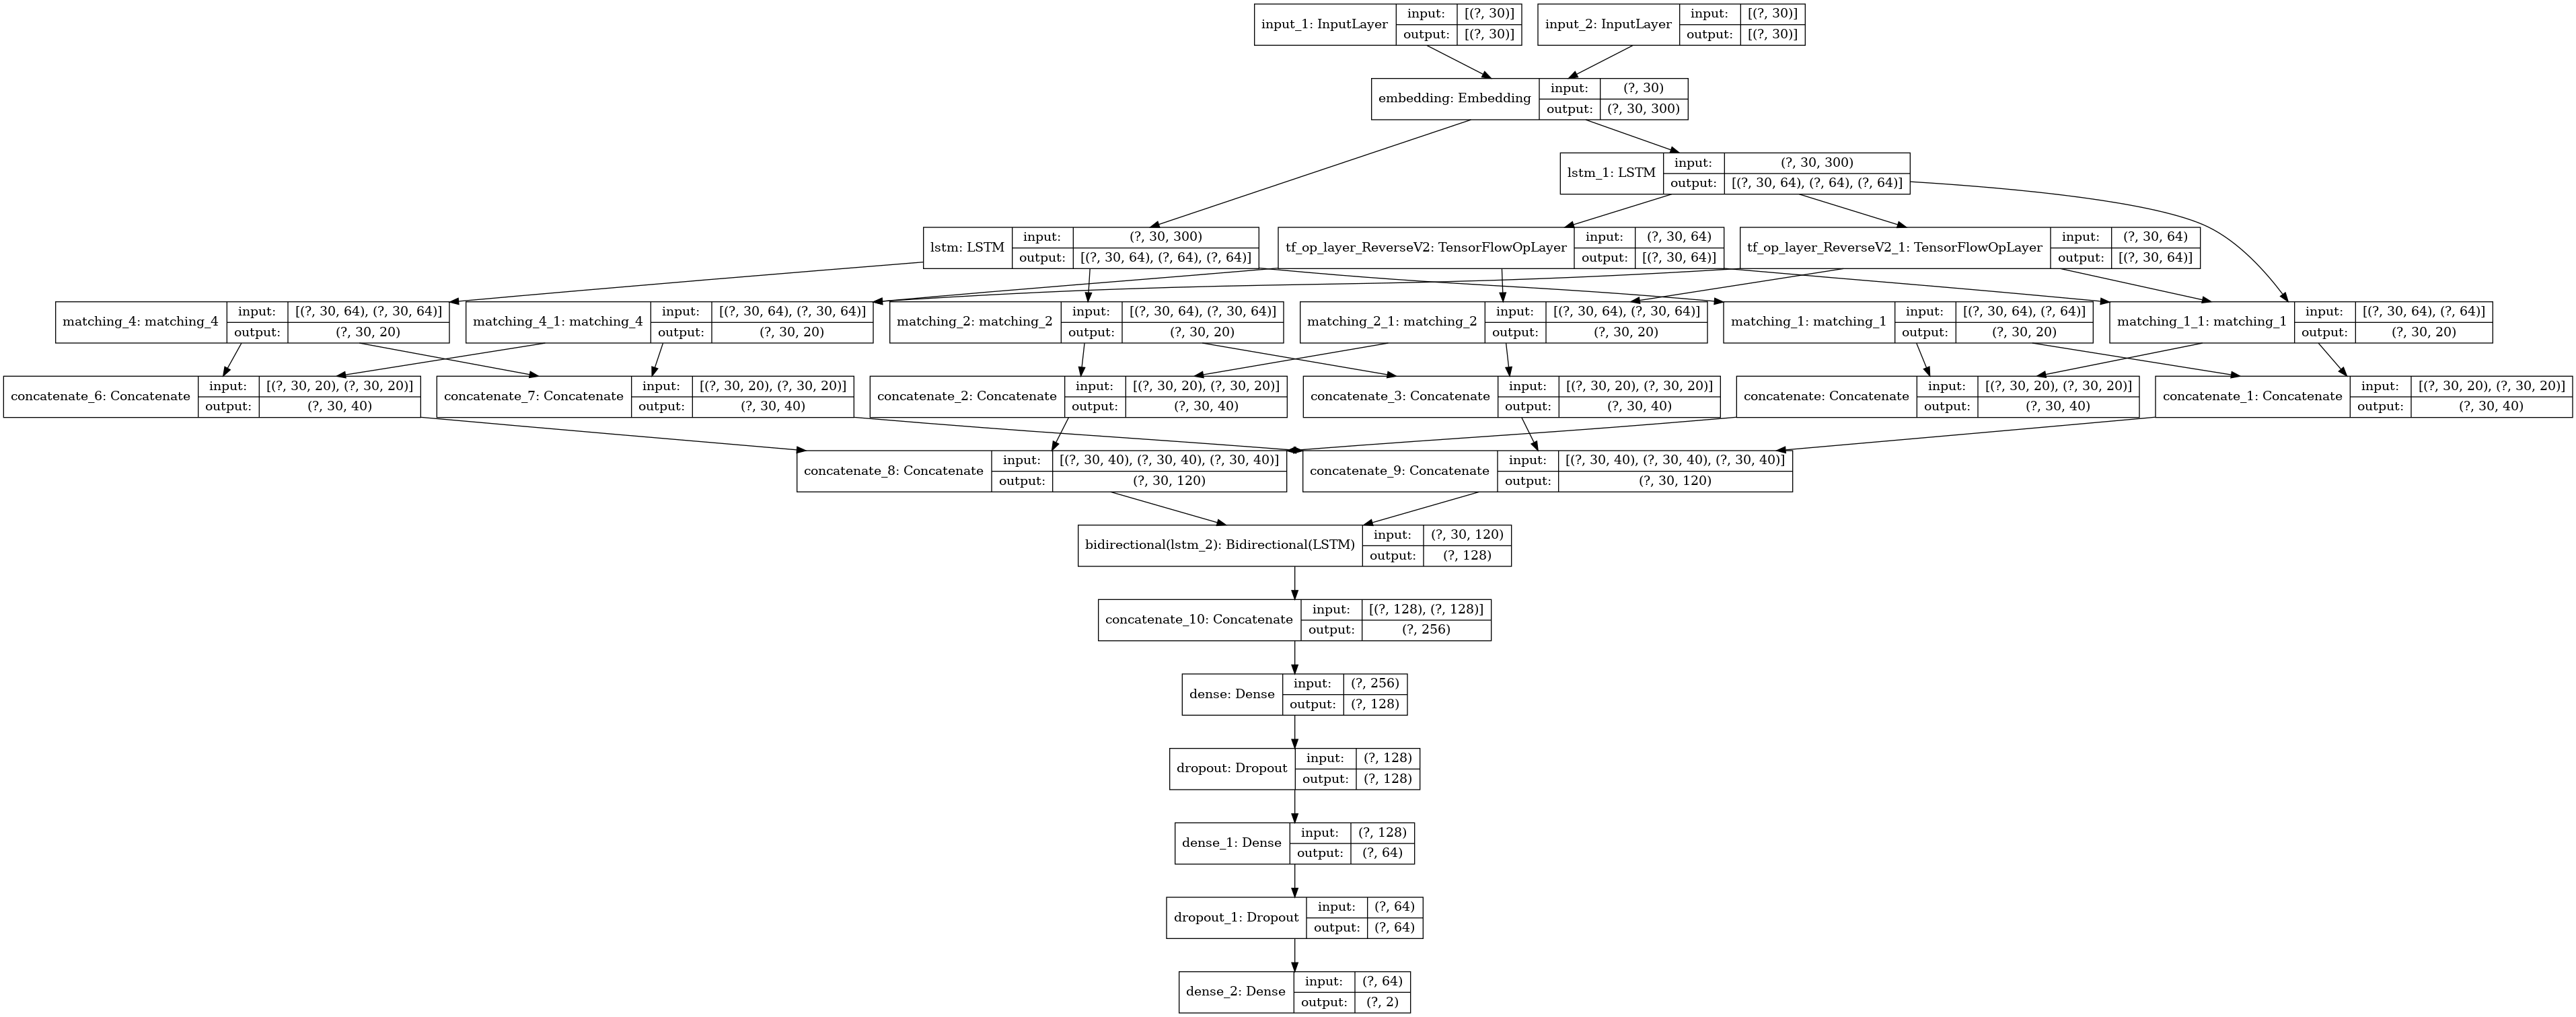

In [37]:
keras.utils.plot_model(model, "BiMPM_1.png", show_shapes=True)

In [38]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer='adam',
    loss=loss,
    metrics=metrics)

In [39]:
# model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
hist = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=32, epochs=5,
                            validation_data=([X_validation[:,0], X_validation[:,1]], Y_validation))

Epoch 1/5
9831/9831 [==============================] - 986s 100ms/step - loss: 0.4322 - accuracy: 0.7868 - val_loss: 0.3787 - val_accuracy: 0.8213
Epoch 2/5
9831/9831 [==============================] - 1013s 103ms/step - loss: 0.3583 - accuracy: 0.8317 - val_loss: 0.3456 - val_accuracy: 0.8422
Epoch 3/5
9831/9831 [==============================] - 1023s 104ms/step - loss: 0.3241 - accuracy: 0.8522 - val_loss: 0.3375 - val_accuracy: 0.8468
Epoch 4/5
9831/9831 [==============================] - 1018s 104ms/step - loss: 0.2997 - accuracy: 0.8659 - val_loss: 0.3293 - val_accuracy: 0.8508
Epoch 5/5
9831/9831 [==============================] - 1030s 105ms/step - loss: 0.2832 - accuracy: 0.8743 - val_loss: 0.3231 - val_accuracy: 0.8528


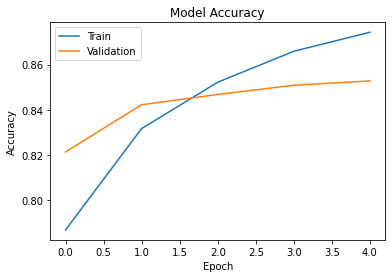

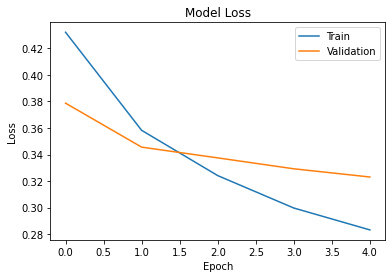

In [41]:
# Plot accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [42]:
model.save_weights("results/BiMPM_qqp",save_format="h5")

In [43]:
with open('results/BiMPM_qqp.json', 'w') as f:
    json.dump(hist.history, f)